# Concept Narratives with Narrative Maps

In [ ]:
import os
import sys

# To make our relative library imports work
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

import umap
import glob
import json
import pandas as pd
import numpy as np
from time import time
from math import pi, sqrt, ceil
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance
from urllib.parse import urlparse
from pulp import *
from sklearn.preprocessing import LabelEncoder
from sklearn.semi_supervised import LabelSpreading
from tqdm import tqdm
from PIL import Image
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

from helpers import extract_image_embeddings, avg_cosine_similarity_metric, dtw_distance_metric
from narrative_maps import (
    extract_varsdict,
    compute_temp_distance_table,
    build_graph,
    graph_stories,
)

## Narrative Maps Linear Program

In [2]:
def create_LP(query, sim_table, membership_vectors, clust_sim_table, exp_temp_table, ent_table, numclust, relevance_table,
              K, mincover, sigma_t, credibility=[], bias=[], operations=[],
              has_start=True, has_end=False, window_time=None, cluster_list=[], start_nodes=[], end_nodes=[],
              verbose=True, force_cluster=True, previous_varsdict=None):
    n = len(query.index)  # We can cut out everything after the end.
    # Variable names and indices
    var_i = []
    var_ij = []
    var_k = [str(k) for k in range(0, numclust)]

    for i in range(0, n):  # This goes up from 0 to n-1.
        var_i.append(str(i))
        for j in window_i_j[i]:
            if i == j:
                print("ERROR IN WINDOW - BASE")
            var_ij.append(str(i) + "_" + str(j))

    # Linear program variable declaration.
    minedge = LpVariable("minedge", lowBound=0, upBound=1)
    node_act_vars = LpVariable.dicts("node_act", var_i, lowBound=0, upBound=1)
    node_next_vars = LpVariable.dicts("node_next", var_ij, lowBound=0, upBound=1)
    # clust_active_vars = LpVariable.dicts("clust_active", var_k, lowBound=0, upBound=1)

    # Create the 'prob' variable to contain the problem data
    prob = LpProblem("StoryChainProblem", LpMaximize)
    # The objective function is added to 'prob' first
    prob += minedge, "WeakestLink"

    # Chain restrictions
    if has_start:
        num_starts = len(start_nodes)
        if verbose:
            print("Start node(s):")
            print(start_nodes)
        if num_starts == 0:  # This is the default when no list is given and it has a start.
            prob += node_act_vars[str(0)] == 1, 'InitialNode'
        else:
            if verbose:
                print("Added start node(s)")
                print("--- %s seconds ---" % (time() - start_time))
            initial_energy = 1.0 / num_starts
            earliest_start = min(start_nodes)
            for node in start_nodes:
                prob += node_act_vars[str(node)] == initial_energy, 'InitialNode' + str(node)
            for node in range(0, earliest_start):
                prob += node_act_vars[str(node)] == 0, 'BeforeStart' + str(node)
    if has_end:
        num_ends = len(end_nodes)
        if verbose:
            print("End node(s):")
            print(end_nodes)
        if num_ends == 0:  # This is the default when no list is given and it has a start.
            prob += node_act_vars[str(n - 1)] == 1, 'FinalNode'
        else:
            if verbose:
                print("Added end node(s)")
                print("--- %s seconds ---" % (time() - start_time))
            final_energy = 1.0 / num_ends
            latest_end = min(end_nodes)
            for node in end_nodes:
                prob += node_act_vars[str(node)] == final_energy, 'FinalNode' + str(node)
            for node in range(latest_end + 1, n):
                prob += node_act_vars[str(node)] == 0, 'AfterEnd' + str(node)

    if verbose:
        print("Chain constraints created.")
        print("--- %s seconds ---" % (time() - start_time))
    prob += lpSum([node_act_vars[i] for i in var_i]) == K, 'KNodes'

    if verbose:
        print("Expected length constraints created.")
        print("--- %s seconds ---" % (time() - start_time))

    if has_start:
        if verbose:
            print("Equality constraints.")
            print("--- %s seconds ---" % (time() - start_time))
        for j in range(1, n):
            if j not in start_nodes:
                prob += lpSum([node_next_vars[str(i) + "_" + str(j)]
                              for i in window_j_i[j]]) == node_act_vars[str(j)], 'InEdgeReq' + str(j)
            else:
                if verbose:
                    print("Generating specific starting node constraints.")
                    print("--- %s seconds ---" % (time() - start_time))
                prob += lpSum([node_next_vars[str(i) + "_" + str(j)]
                              for i in window_j_i[j]]) == 0, 'InEdgeReq' + str(j)
    else:
        if verbose:
            print("Inequality constraints.")
            print("--- %s seconds ---" % (time() - start_time))
        for j in range(1, n):
            prob += lpSum([node_next_vars[str(i) + "_" + str(j)]
                          for i in window_j_i[j]]) <= node_act_vars[str(j)], 'InEdgeReq' + str(j)
    if verbose:
        print("In-degree constraints created.")
        print("--- %s seconds ---" % (time() - start_time))

    if has_end:
        if verbose:
            print("Equality constraints.")
            print("--- %s seconds ---" % (time() - start_time))
        for i in range(0, n - 1):
            if i not in end_nodes:
                prob += lpSum([node_next_vars[str(i) + "_" + str(j)]
                              for j in window_i_j[i]]) == node_act_vars[str(i)], 'OutEdgeReq' + str(i)
            else:
                if verbose:
                    print("Generating specific starting node constraints.")
                    print("--- %s seconds ---" % (time() - start_time))
                prob += lpSum([node_next_vars[str(i) + "_" + str(j)]
                              for j in window_i_j[i]]) == 0, 'OutEdgeReq' + str(i)
    else:
        if verbose:
            print("Inequality constraints.")
            print("--- %s seconds ---" % (time() - start_time))
        for i in range(0, n - 1):
            prob += lpSum([node_next_vars[str(i) + "_" + str(j)]
                          for j in window_i_j[i]]) <= node_act_vars[str(i)], 'OutEdgeReq' + str(i)
    if verbose:
        print("Out-degree constraints created.")
        print("--- %s seconds ---" % (time() - start_time))

    # Objective
    for i in range(0, n):
        for j in window_i_j[i]:
            coherence_weights = [0.5, 0.5]
            # Five or more entities in common means double the connection strength.
            entity_multiplier = min(1 + ent_table[i, j], 2)
            # Geometric mean the relevances, multiply based on how far it is from 0.5.
            relevance_multiplier = (relevance_table[i] * relevance_table[j]) ** 0.5
            coherence = (sim_table[i, j] ** coherence_weights[0]) * \
                (clust_sim_table[i, j] ** coherence_weights[1])

            # Weigh the coherence by IDF
            # Added to the original Narrative Maps model, but not used our final pipeline.
            # This prevents the model from finding meaningful narrative maps.
            # coherence = coherence * idf_vals[spread_labels[j]]

            weighted_coherence = min(coherence * entity_multiplier * relevance_multiplier, 1.0)
            prob += minedge <= 1 - node_next_vars[str(i) + "_" + str(j)] + \
                weighted_coherence, "Objective" + str(i) + "_" + str(j)
    if verbose:
        print("Objective constraints created.")
        print("--- %s seconds ---" % (time() - start_time))

    if previous_varsdict:
        current_names = [v.name for v in prob.variables() if "node_act" in v.name]
        if verbose:
            print("Generated list of names.")
            print("--- %s seconds ---" % (time() - start_time))
        for k, v in previous_varsdict.items():
            if "node_act" in k and k in current_names:
                node_act_vars[k.replace("node_act_", "")].setInitialValue(v)

    if verbose:
        if previous_varsdict:
            print("Used previous solution as starting point.")
            print("--- %s seconds ---" % (time() - start_time))
        else:
            print("No previous solution available.")
            print("--- %s seconds ---" % (time() - start_time))
    # The problem data is written to an .lp file
    return prob

In [3]:
def build_graph_df_multiple_starts(query, varsdict, prune=None, threshold=0.01, cluster_dict={}, start_nodes=[]):
    n = len(query)
    # This has some leftover stuff that is not really useful now.
    if 'bias' in query.columns:
        graph_df = pd.DataFrame(columns=['id', 'adj_list', 'adj_weights',
                                'date', 'publication', 'title', 'text', 'url', 'bias', 'coherence'])
    else:
        graph_df = pd.DataFrame(columns=['id', 'adj_list', 'adj_weights',
                                'date', 'publication', 'title', 'text', 'url', 'coherence'])

    already_in = []
    for i in range(0, n):
        prob = []
        coherence = varsdict["node_act_" + str(i)]
        if coherence <= threshold:
            continue
        coherence_list = []
        index_list = []
        for j in window_i_j[i]:
            name = "node_next_" + str(i) + "_" + str(j)
            prob.append(varsdict[name])
            coherence_list.append(varsdict["node_act_" + str(j)])
        idx_list = [window_i_j[i][idx] for idx, e in enumerate(prob) if round(
            e, 8) != 0 and e > threshold and coherence_list[idx] > threshold]  # idx + i + 1
        nz_prob = [e for idx, e in enumerate(prob) if round(
            e, 8) != 0 and e > threshold and coherence_list[idx] > threshold]
        if prune:
            if len(idx_list) > prune:
                top_prob_idx = sorted(range(len(nz_prob)), key=lambda k: nz_prob[k])[-prune:]
                idx_list = [idx_list[j] for j in top_prob_idx]
                nz_prob = [nz_prob[idx] for idx in top_prob_idx]
        sum_nz = sum(nz_prob)
        nz_prob = [nz_prob[j] / sum_nz for j in range(0, len(nz_prob))]
        # If we haven't checked this one before we add it to the graph.
        url = str(query.iloc[i]['url'])
        if i in already_in or sum_nz > 0:
            if len(url) > 0:
                url = urlparse(url).netloc
            if not (graph_df['id'] == i).any():
                title = query.iloc[i]['title']
                for key, value in cluster_dict.items():
                    if str(i) in value:
                        title = "[" + str(key) + "] " + title
                outgoing_edges = [idx_temp for idx_temp in idx_list]
                # coherence = varsdict["node_act_" + str(i)]
                if 'bias' in query.columns:
                    graph_df.loc[len(graph_df)] = [i, outgoing_edges, nz_prob, query.iloc[i]['date'], query.iloc[i]['publication'],
                                                   title, '', query.iloc[i]['url'], query.iloc[i]['bias'], coherence]
                else:
                    graph_df.loc[len(graph_df)] = [i, outgoing_edges, nz_prob, query.iloc[i]['date'], query.iloc[i]['publication'],
                                                   title, '', query.iloc[i]['url'], coherence]

            already_in += [i] + idx_list
    return graph_df

In [4]:
start_time = None
window_i_j = {}
window_j_i = {}


def solve_LP(
    query,
    dataset,
    membership_vectors,
    K=6,
    mincover=0.20,
    sigma_t=30,
    start_nodes=[],
    end_nodes=[],
    verbose=True,
    force_cluster=True,
    use_entities=True,
    use_temporal=True,
    strict_start=False,
):

    global start_time
    start_time = time()

    n = len(query.index)
    # varsdict_filename = 'varsdict_' + dataset + "_" + str(n) + '.pickle'

    if sigma_t != 0 and use_temporal:
        exp_temp_table = np.exp(-temporal_distance_table / sigma_t)
    else:
        exp_temp_table = np.ones(temporal_distance_table.shape)

    if verbose:
        print("Computed temporal distance table.")
        print("--- %s seconds ---" % (time() - start_time))

    window_time = None
    if sigma_t != 0 and use_temporal:
        window_time = sigma_t * 3  # Days

    if window_time is None:
        for i in range(0, n):
            window_i_j[i] = list(range(i + 1, n))
        for j in range(0, n):
            window_j_i[j] = list(range(0, j))
    else:
        for j in range(0, n):
            window_j_i[j] = []
        for i in range(0, n):
            window_i_j[i] = []
        for i in range(0, n - 1):
            window = 0
            for j in range(i + 1, n):
                if temporal_distance_table[i, j] <= window_time:
                    window += 1
            window = max(min(5, n - i), window)
            window_i_j[i] = list(range(i + 1, min(i + window, n)))
            for j in window_i_j[i]:
                window_j_i[j].append(i)

    if verbose:
        print("Computed temporal windows.")
        print("--- %s seconds ---" % (time() - start_time))

    if verbose:
        print("Computed entity similarities.")
        print("--- %s seconds ---" % (time() - start_time))
    ent_table = np.zeros((n, n))  # Fill entity information with zeros by default.
    actual_ent_table = ent_table
    ent_doc_list = None
    if use_entities:
        ent_table, ent_doc_list = get_entity_table(query, dataset)
        actual_ent_table = ent_table

    # Deprecated relevance table computation
    relevance_table = [1.0] * membership_vectors.shape[0]  # Create a vector full of 1s

    has_start = False
    if start_nodes is not None:
        has_start = (len(start_nodes) > 0)
    if end_nodes is not None:
        has_end = (len(end_nodes) > 0)
    if verbose:
        print("Creating LP...")

    # Read previous solution and feed to LP. If none there is no previous solution.
    previous_varsdict = None

    prob = create_LP(
        query,
        sim_table,
        membership_vectors,
        clust_sim_table,
        exp_temp_table,
        actual_ent_table,
        numclust,
        relevance_table,
        K=K,
        mincover=mincover,
        sigma_t=sigma_t,
        has_start=has_start,
        has_end=has_end,
        start_nodes=start_nodes,
        end_nodes=end_nodes,
        verbose=verbose,
        force_cluster=force_cluster,
        previous_varsdict=previous_varsdict
    )

    if verbose:
        print("Solving model...")
        print("--- %s seconds ---" % (time() - start_time))

    prob.solve(PULP_CBC_CMD(mip=False, warmStart=True, msg=verbose))

    varsdict = extract_varsdict(prob)

    graph_df = build_graph_df_multiple_starts(query, varsdict, prune=ceil(
        sqrt(K)), threshold=0.1 / K, cluster_dict={})

    if verbose:
        print("Graph data frame construction...")
        print("--- %s seconds ---" % (time() - start_time))

    if strict_start and has_start:
        graph_df = graph_clean_up(graph_df, start_nodes)

    if verbose:
        print("Graph clean up...")
        print("--- %s seconds ---" % (time() - start_time))

    return [graph_df, (numclust, LpStatus[prob.status]), sim_table, clust_sim_table, ent_table, ent_doc_list]

## Load the Data

### Load the Images

In [5]:
data_imgs_path = "./roger-dataset"

# This assumes a folder of JPG images exists
data = []
for im_path in tqdm(glob.glob(f"{data_imgs_path}/*.jpg")):
    with open(im_path, 'rb') as file:
        im = Image.open(file)
        im = im.convert('RGB')
        im = im.resize((256, 256), Image.LANCZOS)

        data.append({
            "name": im_path.split("/")[-1],
            "image": np.array(im),
        })

data = pd.DataFrame(data)

data.head()

100%|██████████| 501/501 [00:19<00:00, 25.75it/s]


,name,image
0,TB-ATS-RIO-043.jpg,"[[[69, 69, 69], [74, 74, 74], [78, 78, 78], [7..."
1,TC-SAC-RUI-022.jpg,"[[[104, 104, 104], [116, 116, 116], [122, 122,..."
2,TC-SAC-PIE-004.jpg,"[[[232, 232, 232], [230, 230, 230], [229, 229,..."
3,TC-SAC-PIE-010.jpg,"[[[198, 198, 198], [205, 205, 205], [141, 141,..."
4,TA-LTA-BRC-016.jpg,"[[[60, 60, 60], [65, 65, 65], [71, 71, 71], [7..."


### Load the Embeddings

In [6]:
embeddings, image_names = extract_image_embeddings(
    images=data["image"].tolist(),
    names=data["name"],
    filename=f"./roger-dataset/roger_image_embeddings"
)

image_embeddings = np.array(embeddings)

File './roger-dataset/roger_image_embeddings-detr.pickle' loaded successfully.


In [7]:
data["publication"] = ""
data["url"] = ""
data["title"] = data["name"]
data["embed"] = embeddings.tolist()

### Load the Ground Truths

In [8]:
with open("ground_truth.json") as f:
    ground_truths = json.load(f)

## Label Spreading

### Concatenate the Embedding with the Location Label

In [9]:
location_labels = data["name"].map(lambda x: x.split("-")[-2])

location_label_encoder = LabelEncoder()
location_labels_num = location_label_encoder.fit_transform(location_labels)

location_labels_concat = np.concatenate(
    (
        np.array(data["embed"].tolist()),
        location_labels_num.reshape(-1, 1)
    ),
    axis=1
)

data["embed_location_label"] = location_labels_concat.tolist()

### Spread Category Label
Use the concatenated embedding and location label to spread the category label across all images.

In [ ]:
category_prop_model = LabelSpreading(n_neighbors=16)

category_labels = data["name"].map(lambda x: ground_truths["baseline_labels"].get(x[:-4], ["Unknown", None])[0])
category_label_encoder = LabelEncoder()
category_labels_numeric = category_label_encoder.fit_transform(category_labels)
category_labels_numeric[category_labels_numeric == category_label_encoder.classes_.tolist().index("Unknown")] = -1

category_prop_model.fit(location_labels_concat, category_labels_numeric)

cluster_label_probs = category_label_encoder.classes_[category_prop_model.transduction_]

# Assign the predicted global label to the images
data["label"] = category_label_encoder.classes_[category_prop_model.transduction_].tolist()

umap_model = umap.UMAP(
    n_neighbors=4,
    n_components=64,
    min_dist=0,
    metric="euclidean",
    random_state=42,
)

low_dim_mapper = umap_model.fit(np.array(data["embed_location_label"].tolist()), y=category_prop_model.transduction_) # NOTE!!
low_dim_embeds = low_dim_mapper.embedding_
low_dim_embeds = low_dim_embeds - np.mean(low_dim_embeds, axis=0)

In [11]:
# sns.scatterplot(x=low_dim_embeds[:, 0], y=low_dim_embeds[:, 1], hue=category_prop_model.transduction_, palette="tab20")
# plt.show()

In [12]:
data["embed_ld"] = low_dim_embeds.tolist()

[]

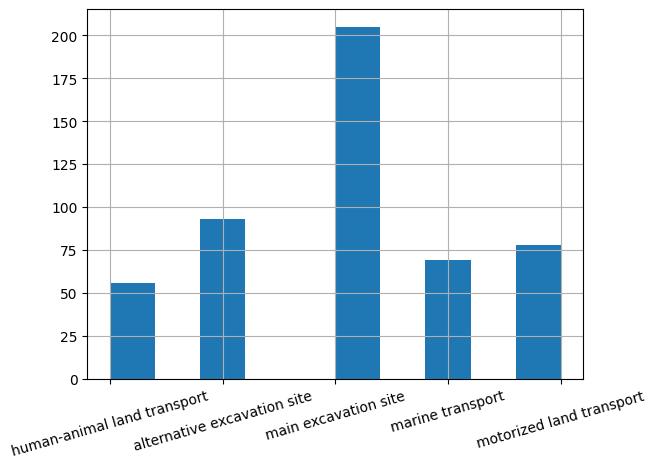

In [13]:
data["label"].hist()
plt.xticks(rotation=16)

plt.plot()

### Spread Date Label
Use the concatenated embedding and location label to spread the date label across all images.

In [14]:
date_prop_model = LabelSpreading(n_neighbors=7)

dates = image_names.map(lambda x: ground_truths["baseline_labels"].get(x[:-4], [None, "Unknown"])[1])
date_encoder = LabelEncoder()
dates_numeric = date_encoder.fit_transform(dates)
dates_numeric[dates_numeric == date_encoder.classes_.tolist().index("Unknown")] = -1

date_prop_model.fit(location_labels_concat, dates_numeric)

# Assign the predicted global label to the images
data["date"] = date_encoder.classes_[date_prop_model.transduction_].tolist()
data["date"] = pd.to_datetime(data["date"].map(lambda x: x + " 01, 1928"), format="%B %d, %Y")

# Sort data by date
data = data.sort_values(by="date").reset_index(drop=True)

[]

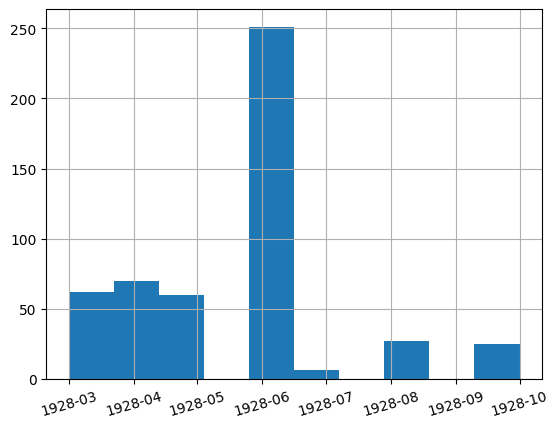

In [15]:
data["date"].hist()
plt.xticks(rotation=16)

plt.plot()

## Evaluations

### Shuffle the Dataset
The Narrative Maps algorithm requires the dataset to be sorted by date. Here, we shuffle the images within each date group to preserve overall chronological order while also inducing randomness to the dataset.

In [16]:
# Grouping and shuffling while keeping idx_1 and idx_2 fixed
def shuffle_group(group, idx_1, idx_2):
    rows = group.index.tolist()

    if idx_1 in rows:
        rows.remove(idx_1)
    if idx_2 in rows:
        rows.remove(idx_2)

    # Shuffle the remaining rows
    shuffled_rows = np.random.permutation(rows).tolist()

    # Insert idx_1 at the beginning and idx_2 at the end if they belong to this group
    if idx_1 in group.index:
        shuffled_rows.insert(0, idx_1)
    if idx_2 in group.index:
        shuffled_rows.append(idx_2)

    return group.loc[shuffled_rows]


def shuffle_within_dates(data, idx1, idx2):
    return data.groupby("date", group_keys=False).apply(shuffle_group, idx_1=idx1, idx_2=idx2)

### TF-IDF Weights
In our final experiments, we did not use the TF-IDS weights. To test this capability, also uncomment line 138 of the `create_LP` function.

In [17]:
# # Compute the IDF of the labels to penalize overly popular categories
# # Both of these variables are used in the LP objective function (the create_LP function).
# spread_labels = data["label"].tolist()
# idf_vals = (data.groupby("label")["label"].count() / 501).to_dict()

# for cat, prob in idf_vals.items():
#     idf_vals[cat] = np.log(1 / prob)

### Similarity Tables
Used by Narrative Map's linear program

In [18]:
def compute_tables(data, cluster_label_probs):
    # Compute angular similarity
    similarities = np.clip(cosine_similarity(np.array(data["embed"].tolist())), -1, 1)
    sim_table = (1 - np.arccos(similarities) / pi)
    mask = np.ones(sim_table.shape, dtype=bool)
    np.fill_diagonal(mask, 0)
    max_value = sim_table[mask].max()
    min_value = sim_table[mask].min()
    sim_table = (sim_table - min_value) / (max_value - min_value)
    sim_table = np.clip(sim_table, 0, 1)

    # Compute topic similarity
    clust_sim = np.zeros((cluster_label_probs.shape[0], cluster_label_probs.shape[0]))

    if len(cluster_label_probs.shape) > 1:
        numclust = cluster_label_probs.shape[1]
        cluster_label_probs[cluster_label_probs < 1 / numclust] = 0
        cluster_label_probs[np.all(cluster_label_probs == 0, axis=1)] = np.ones(numclust) / numclust
        row_sums = cluster_label_probs.sum(axis=1)
        cluster_label_probs = cluster_label_probs / row_sums[:, np.newaxis]

        clust_sim = distance.cdist(
            cluster_label_probs,
            cluster_label_probs,
            lambda u, v: distance.jensenshannon(u, v, base=2.0)
        )
    else:
        numclust = 1
        cluster_label_probs = np.ones((cluster_label_probs.shape[0], 1))

    clust_sim_table = 1 - clust_sim

    # Compute temporal distance
    temporal_distance_table = compute_temp_distance_table(data)

    return numclust, sim_table, clust_sim_table, temporal_distance_table

### Extraction!
Here we extract 20 concept narratives with Narrative Maps for each ground-truth storyline. We also randomly sample images with the same length as the ground truth as a baseline to our model.

In [19]:
# This can take hours to finish, so we save the extracted narratives to a pickle file
try:
    results_data_df_low_d = pd.read_pickle("./results-low-d.pkl")
    results_data_df_high_d =  pd.read_pickle("./results-high-d.pkl")
except FileNotFoundError:
    results_data_low_d = {
        "src": [],
        "tgt": [],
        "nm_storyline": [],
        "rs_storyline": [],
        "baseline_length": [],
        "nm_length": [],
        "rs_length": [],
        "nm_sim_score": [],
        "rs_sim_score": [],
        "nm_dist_score": [],
        "rs_dist_score": [],
    }

    results_data_high_d = {
        "src": [],
        "tgt": [],
        "nm_storyline": [],
        "rs_storyline": [],
        "baseline_length": [],
        "nm_length": [],
        "rs_length": [],
        "nm_sim_score": [],
        "rs_sim_score": [],
        "nm_dist_score": [],
        "rs_dist_score": [],
    }

    for bs_storyline in tqdm(list(ground_truths["baseline_storylines"].values()) * 20):
        baseline_length = len(bs_storyline)
        src_img = bs_storyline[0]+".jpg"
        tgt_img = bs_storyline[-1]+".jpg"

        shuffled_data = shuffle_within_dates(data, src_img, tgt_img).reset_index(names="idx")
        src = shuffled_data[shuffled_data["name"] == src_img].index[0]
        tgt = shuffled_data[shuffled_data["name"] == tgt_img].index[0]

        numclust, sim_table, clust_sim_table, temporal_distance_table = compute_tables(
            shuffled_data,
            cluster_label_probs
        )

        start_time = time()
        graph_df_new, status, _, _, _, _ = solve_LP(
            shuffled_data,
            dataset="news_articles",
            membership_vectors=cluster_label_probs,
            K=baseline_length,
            mincover=0.8,
            sigma_t=0,
            start_nodes=[src],
            end_nodes=[tgt],
            verbose=False,
            use_entities=False,
            use_temporal=False,
            strict_start=False,
        )
        end_time = time() - start_time

        # Post Processing
        if 'Optimal' in status[1]:
            G = build_graph(graph_df_new)
            storylines = graph_stories(G, start_nodes=[src], end_nodes=[tgt])

            if len(storylines) <= 2:
                print(f"Main storyline length is too short. Skipping ({src}) -> ({tgt})...")
                continue

            main_storyline = [int(s) for s in storylines[0]]
            random_sample_storyline = [src, *(shuffled_data.sample(baseline_length - 2)["name"].index), tgt]

            ground_truth = [shuffled_data[shuffled_data["name"] == im_name+".jpg"].index[0] for im_name in bs_storyline]

            # Distance of extracted Narrative Maps storyline to the baseline
            nm_dist_high_d, nm_high_d_dtw_path = dtw_distance_metric(
                embeds=np.array(shuffled_data["embed_location_label"].tolist()),
                true_storyline=ground_truth,
                extracted_storyline=main_storyline
            )

            # Distance of a random sample to the baseline
            rs_dist_high_d, rs_high_d_dtw_path = dtw_distance_metric(
                embeds=np.array(shuffled_data["embed_location_label"].tolist()),
                true_storyline=ground_truth,
                extracted_storyline=random_sample_storyline
            )

            # Similarity of extracted Narrative Maps storyline to the baseline
            nm_sim_high_d = avg_cosine_similarity_metric(
                embeds=np.array(shuffled_data["embed_location_label"].tolist()),
                true_storyline=ground_truth,
                extracted_storyline=main_storyline,
                path=nm_high_d_dtw_path
            )

            # Similarity of a random sample to the baseline
            rs_sim_high_d = avg_cosine_similarity_metric(
                embeds=np.array(shuffled_data["embed_location_label"].tolist()),
                true_storyline=ground_truth,
                extracted_storyline=random_sample_storyline,
                path=rs_high_d_dtw_path
            )

            results_data_high_d["src"].append(src)
            results_data_high_d["tgt"].append(tgt)
            results_data_high_d["nm_storyline"].append(shuffled_data.iloc[main_storyline]["idx"].tolist())
            results_data_high_d["rs_storyline"].append(shuffled_data.iloc[random_sample_storyline]["idx"].tolist())
            results_data_high_d["baseline_length"].append(baseline_length)
            results_data_high_d["nm_length"].append(len(storylines[0]))
            results_data_high_d["rs_length"].append(len(random_sample_storyline))
            results_data_high_d["nm_sim_score"].append(nm_sim_high_d)
            results_data_high_d["rs_sim_score"].append(rs_sim_high_d)
            results_data_high_d["nm_dist_score"].append(nm_dist_high_d)
            results_data_high_d["rs_dist_score"].append(rs_dist_high_d)

            # --------- Low Dimensional Embeddings ---------

            # Distance of extracted Narrative Maps storyline to the baseline
            nm_dist_low_d, nm_low_d_dtw_path = dtw_distance_metric(
                embeds=np.array(shuffled_data["embed_ld"].tolist()),
                true_storyline=ground_truth,
                extracted_storyline=main_storyline
            )

            # Distance of a random sample to the baseline
            rs_dist_low_d, rs_low_d_dtw_path = dtw_distance_metric(
                embeds=np.array(shuffled_data["embed_ld"].tolist()),
                true_storyline=ground_truth,
                extracted_storyline=random_sample_storyline
            )

            # Similarity of extracted Narrative Maps storyline to the baseline
            nm_sim_low_d = avg_cosine_similarity_metric(
                embeds=np.array(shuffled_data["embed_ld"].tolist()),
                true_storyline=ground_truth,
                extracted_storyline=main_storyline,
                path=nm_low_d_dtw_path
            )

            # Similarity of a random sample to the baseline
            rs_sim_low_d = avg_cosine_similarity_metric(
                embeds=np.array(shuffled_data["embed_ld"].tolist()),
                true_storyline=ground_truth,
                extracted_storyline=random_sample_storyline,
                path=rs_low_d_dtw_path
            )

            results_data_low_d["src"].append(src)
            results_data_low_d["tgt"].append(tgt)
            results_data_low_d["nm_storyline"].append(shuffled_data.iloc[main_storyline]["idx"].tolist())
            results_data_low_d["rs_storyline"].append(shuffled_data.iloc[random_sample_storyline]["idx"].tolist())
            results_data_low_d["baseline_length"].append(baseline_length)
            results_data_low_d["nm_length"].append(len(storylines[0]))
            results_data_low_d["rs_length"].append(len(random_sample_storyline))
            results_data_low_d["nm_sim_score"].append(nm_sim_low_d)
            results_data_low_d["rs_sim_score"].append(rs_sim_low_d)
            results_data_low_d["nm_dist_score"].append(nm_dist_low_d)
            results_data_low_d["rs_dist_score"].append(rs_dist_low_d)
        else:
            print(f"Could not extract a narrative")

    results_data_df_high_d = pd.DataFrame(results_data_high_d)
    results_data_df_low_d = pd.DataFrame(results_data_low_d)
    results_data_df_low_d.to_pickle("./results-low-d.pkl")
    results_data_df_high_d.to_pickle("./results-high-d.pkl")

## Evaluation

### High-Dimensional Sim & Dist Analysis

In [20]:
results_data_df_high_d.groupby("baseline_length")[["nm_dist_score", "rs_dist_score"]].mean().round(3)

,nm_dist_score,rs_dist_score
baseline_length,,
5,2.208,2.791
10,2.313,2.615
15,2.215,2.424
20,2.108,2.401
25,1.867,2.408
30,2.026,2.460


In [21]:
for (l, g) in results_data_df_high_d.groupby("baseline_length")[["nm_dist_score", "rs_dist_score"]]:
    print(f"L={l}---------------")
    is_normal_nm = stats.shapiro(g["nm_dist_score"])
    is_normal_rs = stats.shapiro(g["rs_dist_score"])
    print(is_normal_nm.statistic, is_normal_rs.statistic)
    pv = stats.ttest_ind(g["nm_dist_score"], g["rs_dist_score"]).pvalue
    print(pv, pv <= 0.05)
    print()

L=5---------------
0.7445352673530579 0.9292593002319336
0.08380732888955796 False

L=10---------------
0.9605246782302856 0.9631145596504211
0.06807455342132357 False

L=15---------------
0.9139522910118103 0.9607324600219727
0.05156606485156086 False

L=20---------------
0.9747527241706848 0.9584908485412598
0.007856585740066277 True

L=25---------------
0.9734617471694946 0.8944287896156311
0.00011817148155728545 True

L=30---------------
0.9709994792938232 0.9856433868408203
2.147518512835225e-05 True



In [22]:
results_data_df_high_d.groupby("baseline_length")[["nm_sim_score", "rs_sim_score"]].mean().round(3)

,nm_sim_score,rs_sim_score
baseline_length,,
5,0.823,0.841
10,0.915,0.895
15,0.950,0.936
20,0.963,0.945
25,0.960,0.954
30,0.969,0.956


In [23]:
for (l, g) in results_data_df_high_d.groupby("baseline_length")[["nm_sim_score", "rs_sim_score"]]:
    print(f"L={l}---------------")
    is_normal_nm = stats.shapiro(g["nm_sim_score"])
    is_normal_rs = stats.shapiro(g["rs_sim_score"])
    print(is_normal_nm.statistic, is_normal_rs.statistic)
    pv = stats.ttest_ind(g["nm_sim_score"], g["rs_sim_score"]).pvalue
    print(pv, pv <= 0.05)
    print()

L=5---------------
0.9305228590965271 0.8405653238296509
0.31251632815051683 False

L=10---------------
0.914686918258667 0.8679457902908325
0.039922184341635955 True

L=15---------------
0.9493156671524048 0.8844221234321594
0.02568709889437697 True

L=20---------------
0.949504017829895 0.9218124151229858
0.0032501693077997915 True

L=25---------------
0.9598934650421143 0.9398983120918274
0.35140286812052224 False

L=30---------------
0.9718462824821472 0.9594284892082214
0.008664636396793062 True



### Low-Dimensional Sim & Dist Analysis

In [24]:
results_data_df_low_d.groupby("baseline_length")[["nm_dist_score", "rs_dist_score"]].mean().round(3)

,nm_dist_score,rs_dist_score
baseline_length,,
5,8.348,8.331
10,8.691,10.495
15,8.800,10.625
20,8.339,10.086
25,7.258,10.031
30,7.327,10.029


In [25]:
for (l, g) in results_data_df_low_d.groupby("baseline_length")[["nm_dist_score", "rs_dist_score"]]:
    print(f"L={l}---------------")
    is_normal_nm = stats.shapiro(g["nm_dist_score"])
    is_normal_rs = stats.shapiro(g["rs_dist_score"])
    print(is_normal_nm.statistic, is_normal_rs.statistic)
    pv = stats.ttest_ind(g["nm_dist_score"], g["rs_dist_score"]).pvalue
    print(pv, pv <= 0.05)
    print()

L=5---------------
0.866807758808136 0.9075261354446411
0.9821452524233723 False

L=10---------------
0.9473952054977417 0.9200408458709717
0.0008185632567025762 True

L=15---------------
0.9736071825027466 0.9525367617607117
6.070494806994371e-05 True

L=20---------------
0.9402114152908325 0.9491777420043945
3.416200008223354e-05 True

L=25---------------
0.9680529832839966 0.9390729665756226
1.8740756399357085e-11 True

L=30---------------
0.967053234577179 0.9700283408164978
9.394057957303236e-11 True



In [26]:
results_data_df_low_d.groupby("baseline_length")[["nm_sim_score", "rs_sim_score"]].mean().round(3)

,nm_sim_score,rs_sim_score
baseline_length,,
5,0.126,0.094
10,0.299,0.116
15,0.331,0.189
20,0.398,0.252
25,0.480,0.261
30,0.481,0.279


In [27]:
for (l, g) in results_data_df_low_d.groupby("baseline_length")[["nm_sim_score", "rs_sim_score"]]:
    print(f"L={l}---------------")
    is_normal_nm = stats.shapiro(g["nm_sim_score"])
    is_normal_rs = stats.shapiro(g["rs_sim_score"])
    print(is_normal_nm.statistic, is_normal_rs.statistic)
    pv = stats.ttest_ind(g["nm_sim_score"], g["rs_sim_score"]).pvalue
    print(pv, pv <= 0.05)
    print()

L=5---------------
0.9759526252746582 0.9286253452301025
0.7665799652799508 False

L=10---------------
0.9553682208061218 0.9700508713722229
0.0002487769469936925 True

L=15---------------
0.958891749382019 0.9497256875038147
0.000643691235740564 True

L=20---------------
0.9251328706741333 0.9652202129364014
4.994318428304375e-05 True

L=25---------------
0.9785903096199036 0.9437099695205688
1.5609512804799303e-11 True

L=30---------------
0.9429044723510742 0.9335492849349976
1.1133109304161733e-09 True



### Combined Results

In [28]:
import pandas as pd
from scipy import stats
from IPython.display import display

# Helper function to format p-values
def format_pval(p):
    """Format p-values so that values < 0.001 appear in exponential notation."""
    if p < 0.001:
        return f"{p:.1e}"  # e.g. 2.3e-04
    else:
        return f"{p:.4f}"  # e.g. 0.0450

# 1. Compute mean values (rounded) for High-Dimensional Distance
hid_dist_res = results_data_df_high_d.groupby("baseline_length")[["nm_dist_score", "rs_dist_score"]].mean().round(3)

# 1a. Compute p-values for High-Dimensional Distance
hid_dist_pvals = {}
for l, g in results_data_df_high_d.groupby("baseline_length")[["nm_dist_score", "rs_dist_score"]]:
    pv = stats.ttest_ind(g["nm_dist_score"], g["rs_dist_score"]).pvalue
    hid_dist_pvals[l] = format_pval(pv)  # Use the helper function here

# Add p-values to the dataframe
hid_dist_res["dist_pval_HD"] = hid_dist_res.index.map(hid_dist_pvals)

# 2. Compute mean values (rounded) for High-Dimensional Similarity
hid_sim_res = results_data_df_high_d.groupby("baseline_length")[["nm_sim_score", "rs_sim_score"]].mean().round(3)

# 2a. Compute p-values for High-Dimensional Similarity
hid_sim_pvals = {}
for l, g in results_data_df_high_d.groupby("baseline_length")[["nm_sim_score", "rs_sim_score"]]:
    pv = stats.ttest_ind(g["nm_sim_score"], g["rs_sim_score"]).pvalue
    hid_sim_pvals[l] = format_pval(pv)

hid_sim_res["sim_pval_HD"] = hid_sim_res.index.map(hid_sim_pvals)

# 3. Compute mean values (rounded) for Low-Dimensional Distance
low_dist_res = results_data_df_low_d.groupby("baseline_length")[["nm_dist_score", "rs_dist_score"]].mean().round(3)

# 3a. Compute p-values for Low-Dimensional Distance
low_dist_pvals = {}
for l, g in results_data_df_low_d.groupby("baseline_length")[["nm_dist_score", "rs_dist_score"]]:
    pv = stats.ttest_ind(g["nm_dist_score"], g["rs_dist_score"]).pvalue
    low_dist_pvals[l] = format_pval(pv)

low_dist_res["dist_pval_LD"] = low_dist_res.index.map(low_dist_pvals)

# 4. Compute mean values (rounded) for Low-Dimensional Similarity
low_sim_res = results_data_df_low_d.groupby("baseline_length")[["nm_sim_score", "rs_sim_score"]].mean().round(3)

# 4a. Compute p-values for Low-Dimensional Similarity
low_sim_pvals = {}
for l, g in results_data_df_low_d.groupby("baseline_length")[["nm_sim_score", "rs_sim_score"]]:
    pv = stats.ttest_ind(g["nm_sim_score"], g["rs_sim_score"]).pvalue
    low_sim_pvals[l] = format_pval(pv)

low_sim_res["sim_pval_LD"] = low_sim_res.index.map(low_sim_pvals)

# --- Rename columns to be more descriptive ---
hid_dist_res.rename(columns={
    "nm_dist_score": "HD_Dist_NM",
    "rs_dist_score": "HD_Dist_RS"
}, inplace=True)

hid_sim_res.rename(columns={
    "nm_sim_score": "HD_Sim_NM",
    "rs_sim_score": "HD_Sim_RS"
}, inplace=True)

low_dist_res.rename(columns={
    "nm_dist_score": "LD_Dist_NM",
    "rs_dist_score": "LD_Dist_RS"
}, inplace=True)

low_sim_res.rename(columns={
    "nm_sim_score": "LD_Sim_NM",
    "rs_sim_score": "LD_Sim_RS"
}, inplace=True)

# Combine all results into a single DataFrame.
combined_res = pd.concat(
    [hid_sim_res, hid_dist_res, low_sim_res, low_dist_res],
    axis=1
).reset_index()

# Display the final merged table
display(combined_res)

,baseline_length,HD_Sim_NM,HD_Sim_RS,sim_pval_HD,HD_Dist_NM,HD_Dist_RS,dist_pval_HD,LD_Sim_NM,LD_Sim_RS,sim_pval_LD,LD_Dist_NM,LD_Dist_RS,dist_pval_LD
0,5,0.823,0.841,0.3125,2.208,2.791,0.0838,0.126,0.094,0.7666,8.348,8.331,0.9821
1,10,0.915,0.895,0.0399,2.313,2.615,0.0681,0.299,0.116,2.5e-04,8.691,10.495,8.2e-04
2,15,0.950,0.936,0.0257,2.215,2.424,0.0516,0.331,0.189,6.4e-04,8.800,10.625,6.1e-05
3,20,0.963,0.945,0.0033,2.108,2.401,0.0079,0.398,0.252,5.0e-05,8.339,10.086,3.4e-05
4,25,0.960,0.954,0.3514,1.867,2.408,1.2e-04,0.480,0.261,1.6e-11,7.258,10.031,1.9e-11
5,30,0.969,0.956,0.0087,2.026,2.460,2.1e-05,0.481,0.279,1.1e-09,7.327,10.029,9.4e-11
